# README
- Echo State Network（ESN）でFree Spoken Digit Dataset（FSDD）の分類問題を解くプログラムです
- FSDDは6人の話者がzeroからnineまでの数字を発話した音声のデータセットです
- FSDDをLyon Auditory Modelによりコクリアグラムに変換したものをESNに与えます
- このプログラムはGoogle Colaboratoryで動作確認済みです
- このプログラムに関するお問い合わせは 九工大 田中（tanaka-yuichiro@brain.kyutech.ac.jp）まで

# Reservoir

In [1]:
# ESNはNumPyを用いて実装しています

import numpy as np
import copy

In [ ]:
xp = np

In [ ]:
# ESN（リードアウトは含まない）

# 基本的な使い方
# 1. __init__()でレザバーのインスタンスを生成する
# 2. reset()でレザバーの内部状態を初期化する
# 3. __call__()を繰り返し実行し学習用時系列データに対するレザバーの内部状態の時系列を得る
# 4. 学習データの個数に応じて2-3を繰り返す
# 5. ridge_regression()に4で得たレザバーの内部状態の時系列とそれに対応する教師信号を与えリードアウトの結合荷重を得る
# 6. reset()でレザバーの内部状態を初期化する
# 7. __call__()を繰り返し実行し評価用時系列データに対するレザバーの内部状態の時系列を得る
# 8. 7で得たレザバーの内部状態の時系列と5で得た結合荷重を積和演算しESNの出力を得る

class Reservoir(object):
    # コンストラクタ
    def __init__(self, i_size, r_size, i_coef=1.0, r_coef=0.999, sparse=0.5, leak=0.5):
        # i_size: 入力ベクトルのサイズ
        # r_size: レザバーのサイズ
        # i_coef: 入力・レザバー間の結合強度
        # r_coef: レザバー間の結合強度→スペクトル半径
        # sparse: レザバーの結合荷重の結合度（1.0で全結合）
        # leak: LIモデルの漏れ率（0.0で更新なし）

        self.w_i = xp.random.uniform(-i_coef, i_coef, (r_size, i_size)).astype(xp.float32)

        self.w_r = np.random.uniform(-1, 1, (r_size * r_size, )).astype(np.float32)
        self.w_r[0:int(r_size * r_size * (1 - sparse))] = 0
        np.random.shuffle(self.w_r)
        self.w_r = self.w_r.reshape(r_size, r_size)
        self.w_r = self.w_r / max(abs(np.linalg.eig(self.w_r)[0])) * r_coef
        self.w_r = xp.array(self.w_r)

        self.leak = leak


    # レザバーの初期化
    def reset(self, batch):
        # batch: __call__() の引数uのバッチサイズ

        self.x = xp.zeros((batch, self.w_r.shape[0]), dtype=xp.float32)


    # レザバーの内部状態の更新
    # 返り値：更新後のレザバーの内部状態（バッチサイズ，レザバーのサイズ）
    def __call__(self, u):
        # u: 入力ベクトル（バッチサイズ，入力サイズ）

        if not u.shape[0] == self.x.shape[0]:
            print('different batchsize')
            print('required:', self.x.shape[0])
            print('actual:', u.shape[0])

        x_new = xp.tanh(u.dot(self.w_i.T) + self.x.dot(self.w_r.T), dtype=xp.float32)
        self.x = (1 - self.leak) * self.x + self.leak * x_new

        return copy.deepcopy(self.x)


    # バッチ処理のラッパー関数
    # 返り値：出力ベクトル（バッチサイズ，時刻，出力サイズ）
    def reset_and_forward(self, us_batch):
        # us_batch: 入力ベクトル（バッチサイズ，時刻，入力サイズ）

        # レザバーの初期化
        self.reset(batch=us_batch.shape[0])

        # 時系列をレザバーに与える
        us_batch = xp.rollaxis(us_batch, 1, 0)
        hs_batch = [self.__call__(u) for u in us_batch]

        # 返り値
        hs_batch = xp.array(hs_batch, dtype=xp.float32)
        hs_batch = xp.rollaxis(hs_batch, 1, 0)

        return hs_batch

In [ ]:
# リッジ回帰
# 返り値：レザバー・出力間の結合荷重（出力のサイズ，レザバーのサイズ）
def ridge_regression(x, d, norm=1.0):
    # x: レザバーの内部状態の系列（系列長，レザバーのサイズ）
    # t: 教師信号（系列長，出力のサイズ）
    # norm: 正則化項の係数

    array = x.T.dot(x)
    array = array + norm * xp.eye(x.shape[1], dtype=xp.float32)
    array = xp.linalg.inv(array)
    array = array.dot(x.T)
    array = array.dot(d)

    return array.T


# ターゲット信号生成
# 返り値：ターゲット信号（バッチサイズ，時刻，出力サイズ）
def generate_onehot_target(us_batch, l_batch, n_class):
    # us_batch: 入力ベクトル（バッチサイズ，時刻，入力サイズ）
    # l_batch: ラベル（バッチサイズ，）
    # n_class: クラス数

    ts_batch = []
    for us, l in zip(us_batch, l_batch):
        ohv = xp.zeros((us.shape[0], n_class), dtype=xp.float32)
        ohv[:, l] = 1.0
        ts_batch.append(ohv)

    ts_batch = xp.array(ts_batch)
    return ts_batch

# FSDD

In [ ]:
# free spoken digit dataset（FSDD）というフリーのデータセットを使っています
# 6人の話者がzeroからnineまでの数字を発話した音声のデータセットです

!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4260, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 4260 (delta 25), reused 8 (delta 8), pack-reused 4212 (from 1)
Receiving objects: 100% (4260/4260), 30.38 MiB | 38.31 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [ ]:
from scipy.io.wavfile import read
import os

###
# Google Colab仕様のパスになっているので適宜書き換えてください
###
root_path = '/content/free-spoken-digit-dataset/recordings'
filenames = os.listdir(root_path)
person_list = ['jackson', 'nicolas', 'theo', 'yweweler', 'george', 'lucas']

# データ
# x_*：音声
# t_*：ラベル
# t_digit_*：数字を分類するタスクで使うラベル
# t_person_*：話者を分類するタスクで使うラベル
x_train = []
x_test = []
t_digit_train = []
t_digit_test = []
t_person_train = []
t_person_test = []

# train用とtest用に分けています
# Kaggleと同じ方式（のはず）
for filename in filenames:
    digit, person, id = filename.split('.')[0].split('_')
    sr, data = read(os.path.join(root_path, filename))

    # test
    if int(id) < 5:
        x_test.append(data)
        t_digit_test.append(int(digit))
        t_person_test.append(person_list.index(person))

    # train
    else:
        x_train.append(data)
        t_digit_train.append(int(digit))
        t_person_train.append(person_list.index(person))

In [ ]:
# データの長さを8000サンプルで揃えました
# FSDDのサンプルレートは8000Hz→1秒のデータに
LENGTH = 8000

x_train_array = []
for x in x_train:
    zero = np.zeros((1, LENGTH))
    zero[0, :x.shape[0]] = x[:LENGTH]
    x_train_array.append(zero)

x_test_array = []
for x in x_test:
    zero = np.zeros((1, LENGTH))
    zero[0, :x.shape[0]] = x[:LENGTH]
    x_test_array.append(zero)

# 値域が[-1,-1]ではないことに注意
x_train = np.concatenate(x_train_array, axis=0)
x_test = np.concatenate(x_test_array, axis=0)
t_digit_train = np.array(t_digit_train)
t_digit_test = np.array(t_digit_test)
t_person_train = np.array(t_person_train)
t_person_test = np.array(t_person_test)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(t_digit_train.shape)
print(t_digit_test.shape)
print(t_person_train.shape)
print(t_person_test.shape)

(2700, 8000)
(300, 8000)
(2700,)
(300,)
(2700,)
(300,)


In [ ]:
import matplotlib.pyplot as plt

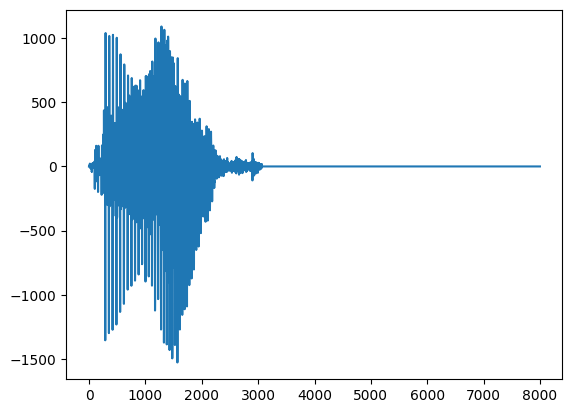

4 3


In [ ]:
# グラフ表示

ID = 1

plt.plot(x_train[ID])
plt.show()

print(t_digit_train[ID], t_person_train[ID])

# FSDD + Lyon

In [ ]:
# Lyon auditory modelを前処理に使いました
# https://github.com/sciforce/lyon

!pip install lyon

In [ ]:
import lyon.calc
calc = lyon.calc.LyonCalc()

In [ ]:
# コクリアグラムへの変換（時間がかかります）

x_train_lyon = []
for x in x_train:
    x = x.astype(np.float64)

    # 前処理
    # decimation_factorは時間方向にどれくらい間引きするかを示すパラメータです
    # 今回は8000→100サンプルに間引きしています
    # 詳しくは下記資料P21を参照
    # https://engineering.purdue.edu/~malcolm/interval/1998-010/AuditoryToolboxTechReport.pdf
    coch = calc.lyon_passive_ear(x, sr, decimation_factor=80)

    x_train_lyon.append(coch)

x_test_lyon = []
for x in x_test:
    x = x.astype(np.float64)
    coch = calc.lyon_passive_ear(x, sr, decimation_factor=80)
    x_test_lyon.append(coch)

# 前処理済みのデータ（インデックス，系列長，次元）
# レザバーの内部変数が32ビットの実装なので，入力データも合わせた方が良いです
x_train_lyon = np.asarray(x_train_lyon, dtype=np.float32)
x_test_lyon = np.asarray(x_test_lyon, dtype=np.float32)

In [ ]:
# 64次元ベクトルが100ステップ
print(x_train_lyon.shape)
print(x_test_lyon.shape)
print(t_digit_train.shape)
print(t_digit_test.shape)
print(t_person_train.shape)
print(t_person_test.shape)

(2700, 100, 64)
(300, 100, 64)
(2700,)
(300,)
(2700,)
(300,)


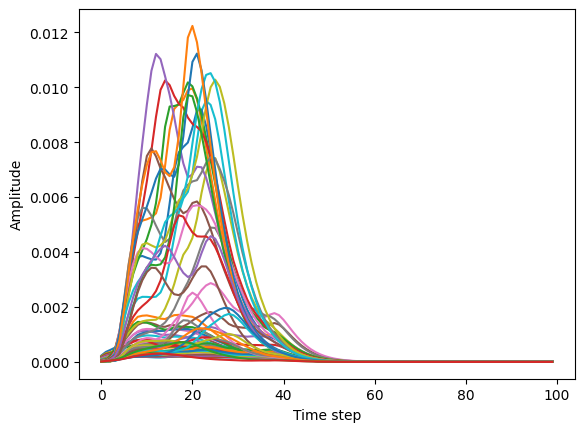

label (digit) 4
label (person) 3


In [ ]:
# グラフ表示（振幅を縦軸にする場合）

ID = 1

plt.plot(x_train_lyon[ID])
plt.xlabel('Time step')
plt.ylabel('Amplitude')
plt.show()

print('label (digit)', t_digit_train[ID])
print('label (person)', t_person_train[ID])

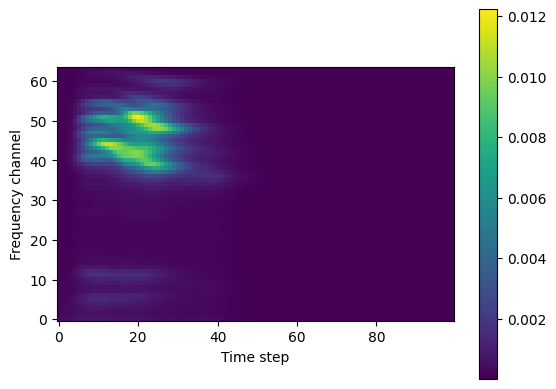

label (digit) 4
label (person) 3


In [ ]:
# グラフ表示（チャンネルのインデックスを縦軸にする場合）

ID = 1

plt.imshow(np.rollaxis(x_train_lyon[ID], 1, 0), origin='lower')
plt.colorbar()
plt.xlabel('Time step')
plt.ylabel('Frequency channel')
plt.show()

print('label (digit)', t_digit_train[ID])
print('label (person)', t_person_train[ID])

# digit recognition task

In [ ]:
# レザバーのノード数を500とする
# コクリアグラムの振幅が小さく，レザバーの内部状態に与える影響が小さいため入力・レザバー間の結合強度をやや大きめに設定した

R_SIZE = 500
reservoir = Reservoir(i_size=64, r_size=R_SIZE, i_coef=30.0, r_coef=0.999, sparse=0.25, leak=0.5)

In [ ]:
# 学習データをレザバーに与える

# バッチサイズ：270
BATCH = 270

hs_all_ = []
ts_all_ = []

for i in range(0, x_train_lyon.shape[0], BATCH):
    # ミニバッチの取得
    x_batch = x_train_lyon[i:i+BATCH]
    l_batch = t_digit_train[i:i+BATCH]

    # レザバーの内部状態取得
    hs_batch = reservoir.reset_and_forward(x_batch)
    hs_all_.append(hs_batch)

    # 教師信号取得
    ts_batch = generate_onehot_target(x_batch, l_batch, n_class=10)
    ts_all_.append(ts_batch)

hs_all_ = xp.concatenate(hs_all_, axis=0).reshape(-1, R_SIZE)
ts_all_ = xp.concatenate(ts_all_, axis=0).reshape(-1, 10)

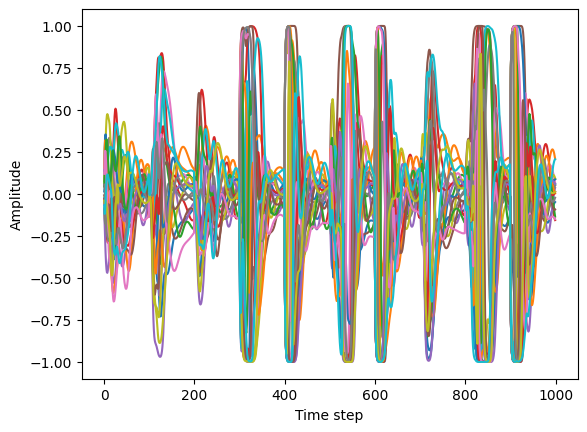

In [ ]:
# レザバーの内部状態の可視化

plt.plot(hs_all_[0:1000, 0:20])
plt.xlabel('Time step')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
# リッジ回帰
w_o_ = ridge_regression(hs_all_, ts_all_, norm=1.0)

In [ ]:
# テストデータをレザバーに与える

# バッチサイズ：100
BATCH = 100

correct = 0.0
count = 0.0

for i in range(0, x_test_lyon.shape[0], BATCH):
    # ミニバッチの取得
    x_batch = x_test_lyon[i:i+BATCH]
    l_batch = t_digit_test[i:i+BATCH]

    # レザバーの出力取得
    hs_batch = reservoir.reset_and_forward(x_batch)
    ys_batch = xp.tensordot(hs_batch, w_o_, axes=(2, 1))

    # 時間方向の平均をとりargmaxを取った結果を推定ラベルとする
    pred_batch = xp.argmax(xp.mean(ys_batch, axis=1), axis=1)

    # カウント
    correct += xp.count_nonzero(pred_batch == l_batch)
    count += BATCH

print('Accuracy:', correct / count)

Accuracy: 0.9


# person recognition task

In [ ]:
# 学習データをレザバーに与える

# バッチサイズ：270
BATCH = 270

hs_all_ = []
ts_all_ = []

for i in range(0, x_train_lyon.shape[0], BATCH):
    # ミニバッチの取得
    x_batch = x_train_lyon[i:i+BATCH]
    l_batch = t_person_train[i:i+BATCH]

    # レザバーの内部状態取得
    hs_batch = reservoir.reset_and_forward(x_batch)
    hs_all_.append(hs_batch)

    # 教師信号取得
    ts_batch = generate_onehot_target(x_batch, l_batch, n_class=6)
    ts_all_.append(ts_batch)

hs_all_ = xp.concatenate(hs_all_, axis=0).reshape(-1, R_SIZE)
ts_all_ = xp.concatenate(ts_all_, axis=0).reshape(-1, 6)

In [ ]:
# リッジ回帰
w_o_ = ridge_regression(hs_all_, ts_all_, norm=1.0)

In [ ]:
# テストデータをレザバーに与える

# バッチサイズ：100
BATCH = 100

correct = 0.0
count = 0.0

for i in range(0, x_test_lyon.shape[0], BATCH):
    # ミニバッチの取得
    x_batch = x_test_lyon[i:i+BATCH]
    l_batch = t_person_test[i:i+BATCH]

    # レザバーの出力取得
    hs_batch = reservoir.reset_and_forward(x_batch)
    ys_batch = xp.tensordot(hs_batch, w_o_, axes=(2, 1))

    # 時間方向の平均をとりargmaxを取った結果を推定ラベルとする
    pred_batch = xp.argmax(xp.mean(ys_batch, axis=1), axis=1)

    # カウント
    correct += xp.count_nonzero(pred_batch == l_batch)
    count += BATCH

print('Accuracy:', correct / count)

Accuracy: 0.9533333333333334
